#  시계열 모델을 이용한 기상데이터 예측

### 목적:

- 서울 지역 시간단위 기상데이터(타깃: 기온) 예측

- 베이스라인: Seasonal Naïve(일주기 24, 주주기 168)

- 주 모델: 직접 구성한 GRU 회귀 모델(PyTorch)

### 데이터 & 기간:
- 2023년(학습/검증), 2024년(테스트)

### 전처리(최소):

- 날짜열 일시 → timestamp 표준화

- ASOS 핵심 변수만 선별(기온/습도/풍속/풍향/현지·해면기압/지면온도/강수/일조/적설)

- 전부 결측인 컬럼 제거(QC 플래그 등)

### 평가 지표: RMSE/MAE

In [ ]:
!pip -q install torch pandas numpy matplotlib scikit-learn

import torch


PyTorch: 2.9.0+cu126


In [1]:
import os, math, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

DEVICE = 'cpu'


### 데이터 로드

In [2]:
weather_2023_path = "/content/weather_seoul_2023.csv"
weather_2024_path = "/content/weather_seoul_2024.csv"



assert os.path.exists(weather_2023_path), f"파일 없음: {weather_2023_path}"
assert os.path.exists(weather_2024_path), f"파일 없음: {weather_2024_path}"




### 데이터 전처리

In [3]:
ASOS_KO = ["기온(°C)","습도(%)","풍속(m/s)","풍향(16방위)",
           "현지기압(hPa)","해면기압(hPa)","지면온도(°C)",
           "강수량(mm)","일조(hr)","적설(cm)"]
ASOS_EN = ["temp","humidity","wind_speed","wind_dir_16",
           "station_pressure","sea_pressure","ground_temp",
           "precip","sunshine_hours","snow_depth"]

RENAME_TO_ENGLISH = True  # 한글 → 영문 컬럼명으로 통일

def read_csv_multi(path):
    for enc in ("utf-8","cp949","euc-kr","utf-8-sig"):
        try:
            return pd.read_csv(path, encoding=enc), enc
        except Exception:
            pass
    return pd.read_csv(path), "utf-8(default)"

def minimal_preprocess(csv_path):
    df, encoding = read_csv_multi(csv_path)

    # 1) 날짜열 표준화
    if "timestamp" not in df.columns:
        if "일시" in df.columns:
            df = df.rename(columns={"일시":"timestamp"})
        else:
            renamed = False
            for c in df.columns:
                lc = str(c).lower()
                if any(k in lc for k in ["time","date","일시","날짜"]):
                    df = df.rename(columns={c:"timestamp"}); renamed = True; break
            if not renamed:
                raise ValueError("날짜열('일시' 또는 'timestamp')이 필요합니다.")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # 2) 핵심 변수 선별
    present_ko = [c for c in ASOS_KO if c in df.columns]
    present_en = [c for c in ASOS_EN if c in df.columns]
    rename_map = {}

    if present_en:
        keep_cols = ["timestamp"] + present_en
    elif present_ko:
        keep_cols = ["timestamp"] + present_ko
        if RENAME_TO_ENGLISH:
            rename_map = {
                "기온(°C)":"temp","습도(%)":"humidity","풍속(m/s)":"wind_speed",
                "풍향(16방위)":"wind_dir_16","현지기압(hPa)":"station_pressure",
                "해면기압(hPa)":"sea_pressure","지면온도(°C)":"ground_temp",
                "강수량(mm)":"precip","일조(hr)":"sunshine_hours","적설(cm)":"snow_depth"
            }
    else:
        numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
        keep_cols = ["timestamp"] + numeric_cols

    df = df[keep_cols]

    # 3) 전부 결측 컬럼 제거
    all_nan_cols = [c for c in df.columns if c!="timestamp" and df[c].isna().all()]
    if all_nan_cols:
        df = df.drop(columns=all_nan_cols)

    if rename_map:
        rename_map = {k:v for k,v in rename_map.items() if k in df.columns}
        df = df.rename(columns=rename_map)

    # 정렬/중복 제거
    df = df.sort_values("timestamp").drop_duplicates("timestamp").reset_index(drop=True)
    return df, encoding, all_nan_cols

weather_2023, enc23, dropped23 = minimal_preprocess(weather_2023_path)
weather_2024, enc24, dropped24 = minimal_preprocess(weather_2024_path)


In [4]:
TIME_COL = "timestamp"

# 두 연도의 공통 컬럼만 사용
common_cols = [c for c in weather_2023.columns if c in weather_2024.columns]
if TIME_COL not in common_cols:
    common_cols = [TIME_COL] + [c for c in common_cols if c != TIME_COL]

weather_2023 = weather_2023[common_cols].copy()
weather_2024 = weather_2024[common_cols].copy()

# 타깃 선정
TARGET_COL = "temp" if "temp" in common_cols else ("기온(°C)" if "기온(°C)" in common_cols else None)
assert TARGET_COL is not None, "타깃 컬럼(temp/기온(°C))이 필요합니다."

# (고정) 피처 집합: 시간/타깃을 제외한 나머지
fixed_features = [c for c in common_cols if c not in [TIME_COL, TARGET_COL]]
print("고정 피처 수:", len(fixed_features), "| 타깃:", TARGET_COL)


고정 피처 수: 9 | 타깃: temp


In [5]:
def hourly_interpolate_safe(df, time_col, feature_cols, target_col):
    cols = [time_col] + feature_cols + [target_col]
    g = df[cols].copy()

    # 숫자 강제 변환(문자/기호 → NaN)
    for c in feature_cols + [target_col]:
        g[c] = pd.to_numeric(g[c], errors="coerce")

    # 시간 인덱스 정렬 → 1시간 격자 → 시간보간 → 앞/뒤 채우기
    g = g.set_index(time_col).sort_index()
    g = g.asfreq("1h")
    g[feature_cols + [target_col]] = (
        g[feature_cols + [target_col]]
        .interpolate(method="time")
        .ffill()
        .bfill()
    )
    return g.reset_index()

weather_2023 = hourly_interpolate_safe(weather_2023, TIME_COL, fixed_features, TARGET_COL)
weather_2024 = hourly_interpolate_safe(weather_2024, TIME_COL, fixed_features, TARGET_COL)

print("2023 기간:", weather_2023[TIME_COL].min(), "→", weather_2023[TIME_COL].max(), "| 행:", len(weather_2023))
print("2024 기간:", weather_2024[TIME_COL].min(), "→", weather_2024[TIME_COL].max(), "| 행:", len(weather_2024))


2023 기간: 2023-01-01 00:00:00 → 2024-01-01 00:00:00 | 행: 8761
2024 기간: 2024-01-01 00:00:00 → 2025-01-01 00:00:00 | 행: 8785


In [6]:
train_23 = weather_2023[weather_2023[TIME_COL] < "2023-11-01"]
val_23   = weather_2023[(weather_2023[TIME_COL] >= "2023-11-01") & (weather_2023[TIME_COL] < "2024-01-01")]
test_24  = weather_2024

print("Train23:", train_23[TIME_COL].min(), "→", train_23[TIME_COL].max(), len(train_23))
print("Val23  :", val_23[TIME_COL].min(),   "→", val_23[TIME_COL].max(),   len(val_23))
print("Test24 :", test_24[TIME_COL].min(),  "→", test_24[TIME_COL].max(),  len(test_24))


Train23: 2023-01-01 00:00:00 → 2023-10-31 23:00:00 7296
Val23  : 2023-11-01 00:00:00 → 2023-12-31 23:00:00 1464
Test24 : 2024-01-01 00:00:00 → 2025-01-01 00:00:00 8785


In [7]:
def xy(block, features, target):
    X = block[features].values
    y = block[[target]].values
    return X, y

X_tr_raw, y_tr_raw = xy(train_23, fixed_features, TARGET_COL)
X_va_raw, y_va_raw = xy(val_23,   fixed_features, TARGET_COL)
X_te_raw, y_te_raw = xy(test_24,  fixed_features, TARGET_COL)

scaler_x, scaler_y = StandardScaler(), StandardScaler()
X_tr = scaler_x.fit_transform(X_tr_raw); y_tr = scaler_y.fit_transform(y_tr_raw)
X_va = scaler_x.transform(X_va_raw);     y_va = scaler_y.transform(y_va_raw)
X_te = scaler_x.transform(X_te_raw);     y_te = scaler_y.transform(y_te_raw)

def keep_finite(x, y):
    m = np.isfinite(x).all(axis=1) & np.isfinite(y).all(axis=1)
    return x[m], y[m]

X_tr, y_tr = keep_finite(X_tr, y_tr)
X_va, y_va = keep_finite(X_va, y_va)
X_te, y_te = keep_finite(X_te, y_te)

INPUT_LEN, HORIZON = 72, 1

def make_windows(x, y, L=72, H=1, stride=1):
    Xs, Ys = [], []
    for s in range(0, len(x)-L-H+1, stride):
        e = s+L; t = e+H-1
        Xs.append(x[s:e]); Ys.append(y[t])
    return np.stack(Xs), np.stack(Ys)

X_tr_w, y_tr_w = make_windows(X_tr, y_tr, INPUT_LEN, HORIZON, 1)
X_va_w, y_va_w = make_windows(X_va, y_va, INPUT_LEN, HORIZON, 1)
X_te_w, y_te_w = make_windows(X_te, y_te, INPUT_LEN, HORIZON, 1)

print("윈도우 차원:", X_tr_w.shape, y_tr_w.shape, "| feature_dim =", X_tr_w.shape[-1])


윈도우 차원: (7224, 72, 9) (7224, 1) | feature_dim = 9


In [8]:
class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH_TRAIN, BATCH_EVAL = 128, 256
train_loader = DataLoader(SeqDS(X_tr_w,y_tr_w), batch_size=BATCH_TRAIN, shuffle=True, drop_last=True)
val_loader   = DataLoader(SeqDS(X_va_w,y_va_w), batch_size=BATCH_EVAL,  shuffle=False)
test_loader  = DataLoader(SeqDS(X_te_w,y_te_w), batch_size=BATCH_EVAL,  shuffle=False)


In [22]:
def seasonal_naive_eval(df_block, target_col, s):
    """
    Seasonal Naïve 평가: ŷ_t = y_{t-s}
    df_block: 시계열 데이터프레임
    target_col: 타깃 컬럼명
    s: 계절 주기(예: 24=일주기, 168=주주기)
    """
    # 시간축 1시간 격자화 + 시간보간 → 단일 시계열 생성
    ser = (
        df_block[[TIME_COL, target_col]]
        .set_index(TIME_COL).asfreq("1h")
        .interpolate(method="time")
    )[target_col]

    y = ser.values.astype(float)
    yhat = np.full_like(y, np.nan, dtype=float)

    # 계절성 시프트로 예측값 생성(ŷ_t = y_{t-s})
    for t in range(s, len(y)):
        yhat[t] = y[t - s]

    # 유효 구간만 지표 계산
    mask = ~np.isnan(yhat)
    mae = mean_absolute_error(y[mask], yhat[mask])
    mse = mean_squared_error(y[mask], yhat[mask])
    rmse = float(np.sqrt(mse))
    return mae, rmse


# s=24(하루), 168(일주일) 두 베이스라인 출력
for s, name in [(24, "Daily(24)"), (168, "Weekly(168)")]:
    mae_v, rmse_v = seasonal_naive_eval(val_23, TARGET_COL, s)
    mae_t, rmse_t = seasonal_naive_eval(test_24, TARGET_COL, s)
    print(f"[Seasonal Naive {name}]  VAL23 MAE={mae_v:.3f} RMSE={rmse_v:.3f} | TEST24 MAE={mae_t:.3f} RMSE={rmse_t:.3f}")

[Seasonal Naive Daily(24)]  VAL23 MAE=3.304 RMSE=4.377 | TEST24 MAE=2.263 RMSE=3.115
[Seasonal Naive Weekly(168)]  VAL23 MAE=7.994 RMSE=10.031 | TEST24 MAE=3.574 RMSE=4.645


### GRU 모델 정의

In [14]:
class GRURegressor(nn.Module):
    """GRU로 시계열 입력(B,T,F) → 1시간 뒤 스칼라(B,1) 예측"""
    def __init__(self, in_dim: int, hid: int = 128, layers: int = 2, dropout: float = 0.1):
        super().__init__()
        # GRU 본체: 시점별 피처(F) → 은닉(H), 층 수(layers)
        self.gru = nn.GRU(
            input_size=in_dim,
            hidden_size=hid,
            num_layers=layers,
            dropout=dropout if layers > 1 else 0.0,  # layers=1이면 무시
            batch_first=True
        )
        # 회귀 헤드: 마지막 은닉(H) → 스칼라(1)
        self.head = nn.Sequential(
            nn.Linear(hid, hid // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hid // 2, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # GRU 출력 전체 시점 은닉(B,T,H)
        h, _ = self.gru(x)
        # 마지막 시점 은닉만 사용 → 회귀 헤드
        return self.head(h[:, -1, :])

# 사용 예시
IN_DIM = int(X_tr_w.shape[-1])       # 입력 피처 수(F)
model = GRURegressor(IN_DIM, hid=128, layers=1, dropout=0.1).to(DEVICE)

# 간단 점검: 한 샘플 forward
with torch.no_grad():
    _ = model(torch.tensor(X_tr_w[:1], dtype=torch.float32).to(DEVICE))
print("✅ 모델 input_size =", model.gru.input_size, "| 데이터 feature_dim =", IN_DIM)

✅ 모델 input_size = 9 | 데이터 feature_dim = 9


In [15]:
def inv_y(arr): return scaler_y.inverse_transform(arr)

def evaluate(model, loader):
    model.eval(); mse=mae=n=0.0; ys=[]; ps=[]
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = model(xb)
            y_np = inv_y(yb.cpu().numpy()); p_np = inv_y(pred.cpu().numpy())
            m = np.isfinite(y_np).all(axis=1) & np.isfinite(p_np).all(axis=1)
            if not m.any(): continue
            y_np, p_np = y_np[m], p_np[m]
            ys.append(y_np); ps.append(p_np)
            mse += ((p_np - y_np)**2).sum()
            mae += np.abs(p_np - y_np).sum()
            n   += len(y_np)
    if n == 0:
        return np.nan, np.nan, np.empty((0,1)), np.empty((0,1))
    rmse = math.sqrt(mse/n); mae = mae/n
    return rmse, mae, (np.concatenate(ys) if ys else np.empty((0,1))), (np.concatenate(ps) if ps else np.empty((0,1)))

def train_model(model, epochs=30, lr=1e-3, patience=6):
    crit = nn.MSELoss(); opt = torch.optim.AdamW(model.parameters(), lr=lr)
    best=float("inf"); bad=0; saved=False
    for ep in range(1, epochs+1):
        model.train(); tot=0.0
        for xb,yb in train_loader:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            loss = crit(model(xb), yb)
            if torch.isnan(loss):
                continue
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item()*len(xb)
        rmse_v, mae_v, _, _ = evaluate(model, val_loader)
        print(f"[{ep:02d}] train_loss={(tot/len(train_loader.dataset)):.5f} | val_RMSE={rmse_v:.3f} val_MAE={mae_v:.3f}")
        if np.isfinite(rmse_v) and rmse_v < best:
            best=rmse_v; bad=0; torch.save(model.state_dict(),"best.pt"); saved=True
        else:
            bad+=1
            if bad>=patience:
                print("Early stopping"); break
    if not saved:
        torch.save(model.state_dict(),"best.pt")


[01] train_loss=0.23266 | val_RMSE=2.439 val_MAE=1.955
[02] train_loss=0.04056 | val_RMSE=2.124 val_MAE=1.686
[03] train_loss=0.02972 | val_RMSE=2.108 val_MAE=1.687
[04] train_loss=0.02337 | val_RMSE=2.062 val_MAE=1.649
[05] train_loss=0.02027 | val_RMSE=2.072 val_MAE=1.700
[06] train_loss=0.01835 | val_RMSE=2.155 val_MAE=1.772
[07] train_loss=0.01691 | val_RMSE=1.828 val_MAE=1.430
[08] train_loss=0.01605 | val_RMSE=1.950 val_MAE=1.559
[09] train_loss=0.01525 | val_RMSE=1.882 val_MAE=1.472
[10] train_loss=0.01477 | val_RMSE=1.943 val_MAE=1.592
[11] train_loss=0.01417 | val_RMSE=1.994 val_MAE=1.612
[12] train_loss=0.01390 | val_RMSE=1.732 val_MAE=1.371
[13] train_loss=0.01320 | val_RMSE=1.941 val_MAE=1.541
[14] train_loss=0.01249 | val_RMSE=1.924 val_MAE=1.583
[15] train_loss=0.01298 | val_RMSE=1.784 val_MAE=1.406
[16] train_loss=0.01159 | val_RMSE=1.942 val_MAE=1.604
[17] train_loss=0.01190 | val_RMSE=1.760 val_MAE=1.382
[18] train_loss=0.01202 | val_RMSE=1.845 val_MAE=1.504
Early stop

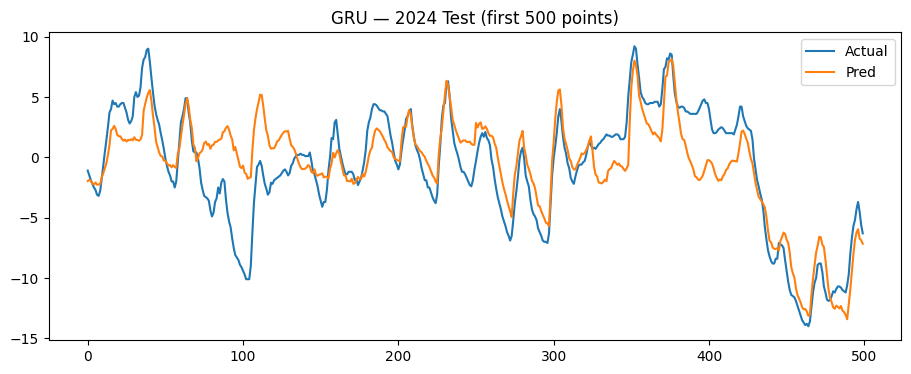

In [16]:
train_model(model, epochs=30, lr=1e-3, patience=6)

model.load_state_dict(torch.load("best.pt", map_location=DEVICE))
rmse_te, mae_te, y_true, y_pred = evaluate(model, test_loader)
print(f"[GRU TEST24] RMSE={rmse_te:.3f} | MAE={mae_te:.3f}")

plt.figure(figsize=(11,4))
N = min(500, len(y_true))
plt.plot(y_true[:N], label="Actual"); plt.plot(y_pred[:N], label="Pred")
plt.title("GRU — 2024 Test (first 500 points)")
plt.legend(); plt.show()


### CNN + GRU 하이브리드 정의

In [17]:
class CNNGRURegressor(nn.Module):
    """1D-CNN으로 국소 패턴 추출 → GRU로 시계열 의존성 학습 → 스칼라 예측"""
    def __init__(self, in_dim, conv_channels=128, kernel_size=5, gru_hid=128, gru_layers=2, dropout=0.1):
        super().__init__()
        padding = kernel_size // 2
        # CNN: (B,T,F) 전치 → (B,F,T), 1D-Conv로 시점축 패턴 추출 → 채널 C 생성
        self.conv = nn.Sequential(
            nn.Conv1d(in_dim, conv_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv1d(conv_channels, conv_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # GRU: CNN 출력 채널(C)을 피처로 보고 시계열 의존성 모델링
        self.gru = nn.GRU(
            input_size=conv_channels, hidden_size=gru_hid,
            num_layers=gru_layers, dropout=dropout if gru_layers > 1 else 0.0,
            batch_first=True
        )
        # 회귀 헤드: 마지막 시점 은닉 → 스칼라(1)
        self.head = nn.Sequential(
            nn.Linear(gru_hid, gru_hid // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(gru_hid // 2, 1)
        )

    def forward(self, x):  # x: (B, T, F)
        x = x.transpose(1, 2)        # (B,F,T)로 전치 → Conv 입력
        x = self.conv(x)             # CNN 특징맵 (B,C,T)
        x = x.transpose(1, 2)        # (B,T,C)로 전치 → GRU 입력
        h, _ = self.gru(x)           # GRU 은닉 (B,T,H)
        return self.head(h[:, -1, :])  # 마지막 시점 은닉 → (B,1)

[01] train_loss=0.01478 | val_RMSE=1.944 val_MAE=1.599
[02] train_loss=0.01262 | val_RMSE=1.936 val_MAE=1.528
[03] train_loss=0.01264 | val_RMSE=1.972 val_MAE=1.609
[04] train_loss=0.01173 | val_RMSE=1.883 val_MAE=1.538
[05] train_loss=0.01174 | val_RMSE=1.878 val_MAE=1.498
[06] train_loss=0.01192 | val_RMSE=2.080 val_MAE=1.727
[07] train_loss=0.01103 | val_RMSE=1.848 val_MAE=1.521
[08] train_loss=0.01088 | val_RMSE=1.877 val_MAE=1.536
[09] train_loss=0.01000 | val_RMSE=1.764 val_MAE=1.382
[10] train_loss=0.01069 | val_RMSE=1.856 val_MAE=1.477
[11] train_loss=0.01028 | val_RMSE=1.782 val_MAE=1.410
[12] train_loss=0.00963 | val_RMSE=1.848 val_MAE=1.494
[13] train_loss=0.00939 | val_RMSE=1.924 val_MAE=1.579
[14] train_loss=0.00981 | val_RMSE=1.857 val_MAE=1.494
[15] train_loss=0.00921 | val_RMSE=1.864 val_MAE=1.490
Early stopping
[CNN+GRU TEST24] RMSE=1.906 | MAE=1.528


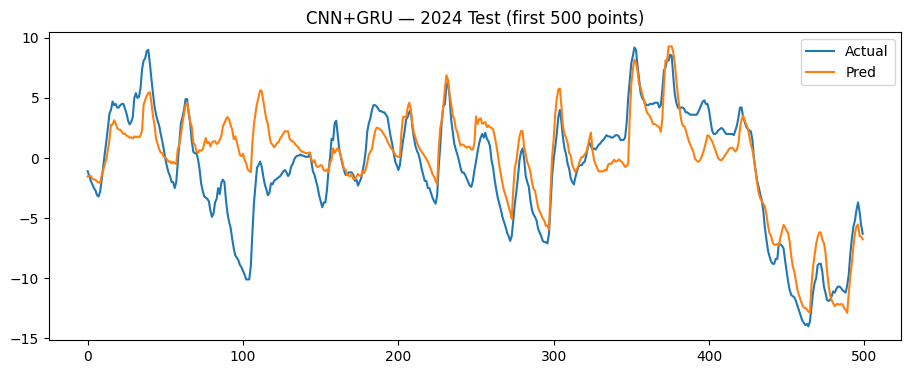

In [18]:
# === CNN+GRU 학습 → best 로드 → 평가/시각화 ===

# 1) 학습 (best.pt 저장)
train_model(model, epochs=30, lr=1e-3, patience=6)

# (선택) 실험별 체크포인트 백업
import os, shutil
if os.path.exists("best.pt"):
    shutil.copyfile("best.pt", "best_cnn_gru.pt")

# 2) best 로드 & 테스트 평가
model.load_state_dict(torch.load("best.pt", map_location=DEVICE))
rmse_te, mae_te, y_true, y_pred = evaluate(model, test_loader)
print(f"[CNN+GRU TEST24] RMSE={rmse_te:.3f} | MAE={mae_te:.3f}")

# 3) 시각화 (첫 500시간)
import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
N = min(500, len(y_true))
plt.plot(y_true[:N], label="Actual")
plt.plot(y_pred[:N], label="Pred")
plt.title("CNN+GRU — 2024 Test (first 500 points)")
plt.legend(); plt.show()

In [ ]:
IN_DIM = int(X_tr_w.shape[-1])
model = CNNGRURegressor(IN_DIM, conv_channels=128, kernel_size=5, gru_hid=128, gru_layers=2, dropout=0.1).to(DEVICE)
train_model(model, epochs=30, lr=1e-3, patience=6)

[01] train_loss=0.16001 | val_RMSE=2.639 val_MAE=2.086
[02] train_loss=0.03449 | val_RMSE=2.934 val_MAE=2.453
[03] train_loss=0.02472 | val_RMSE=2.912 val_MAE=2.422
[04] train_loss=0.02002 | val_RMSE=2.497 val_MAE=2.089
[05] train_loss=0.01898 | val_RMSE=2.763 val_MAE=2.334
[06] train_loss=0.01701 | val_RMSE=2.350 val_MAE=1.930
[07] train_loss=0.01470 | val_RMSE=2.454 val_MAE=2.050
[08] train_loss=0.01467 | val_RMSE=2.250 val_MAE=1.801
[09] train_loss=0.01394 | val_RMSE=2.383 val_MAE=1.926
[10] train_loss=0.01283 | val_RMSE=2.345 val_MAE=1.908
[11] train_loss=0.01287 | val_RMSE=2.206 val_MAE=1.776
[12] train_loss=0.01123 | val_RMSE=2.206 val_MAE=1.778
[13] train_loss=0.01061 | val_RMSE=2.142 val_MAE=1.745
[14] train_loss=0.01120 | val_RMSE=2.316 val_MAE=1.895
[15] train_loss=0.01192 | val_RMSE=3.379 val_MAE=2.838
[16] train_loss=0.01132 | val_RMSE=2.224 val_MAE=1.728
[17] train_loss=0.01143 | val_RMSE=2.534 val_MAE=2.105
[18] train_loss=0.00997 | val_RMSE=2.300 val_MAE=1.890
[19] train

### LSTM 모델 정의

In [19]:
class LSTMRegressor(nn.Module):
    """LSTM으로 시계열(B,T,F) → 1시간 뒤 스칼라(B,1) 예측"""
    def __init__(self, in_dim, hid=128, layers=2, dropout=0.1, bidirectional=False):
        super().__init__()
        self.bidirectional = bidirectional
        # LSTM 본체: 시점 의존성 학습 (양방향 옵션 지원)
        self.lstm = nn.LSTM(
            input_size=in_dim, hidden_size=hid,
            num_layers=layers,
            dropout=dropout if layers > 1 else 0.0,  # layers=1이면 무시
            batch_first=True, bidirectional=bidirectional
        )
        out_dim = hid * (2 if bidirectional else 1)
        # 회귀 헤드: 마지막 시점 은닉 → 스칼라(1)
        self.head = nn.Sequential(
            nn.Linear(out_dim, out_dim // 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(out_dim // 2, 1)
        )

    def forward(self, x):  # x: (B, T, F)
        h, _ = self.lstm(x)          # (B, T, H) 또는 (B, T, 2H)
        return self.head(h[:, -1, :])  # 마지막 시점 은닉 → (B,1)

In [20]:
IN_DIM = int(X_tr_w.shape[-1])     # 윈도우의 피처 수
model = LSTMRegressor(
    in_dim=IN_DIM,
    hid=128,
    layers=2,
    dropout=0.1,
    bidirectional=False,
).to(DEVICE)

# 간단 차원 점검
with torch.no_grad():
    _ = model(torch.tensor(X_tr_w[:1], dtype=torch.float32).to(DEVICE))
print("✅ LSTM input_size =", model.lstm.input_size, "| feature_dim =", IN_DIM)


✅ LSTM input_size = 9 | feature_dim = 9


[01] train_loss=0.27398 | val_RMSE=3.105 val_MAE=2.593
[02] train_loss=0.04218 | val_RMSE=2.260 val_MAE=1.842
[03] train_loss=0.03318 | val_RMSE=2.164 val_MAE=1.759
[04] train_loss=0.02669 | val_RMSE=1.969 val_MAE=1.553
[05] train_loss=0.02456 | val_RMSE=2.226 val_MAE=1.776
[06] train_loss=0.02168 | val_RMSE=2.168 val_MAE=1.676
[07] train_loss=0.02058 | val_RMSE=2.307 val_MAE=1.893
[08] train_loss=0.02004 | val_RMSE=2.478 val_MAE=2.008
[09] train_loss=0.01852 | val_RMSE=2.101 val_MAE=1.705
[10] train_loss=0.01714 | val_RMSE=2.087 val_MAE=1.714
Early stopping
[LSTM TEST24] RMSE=2.218 | MAE=1.779


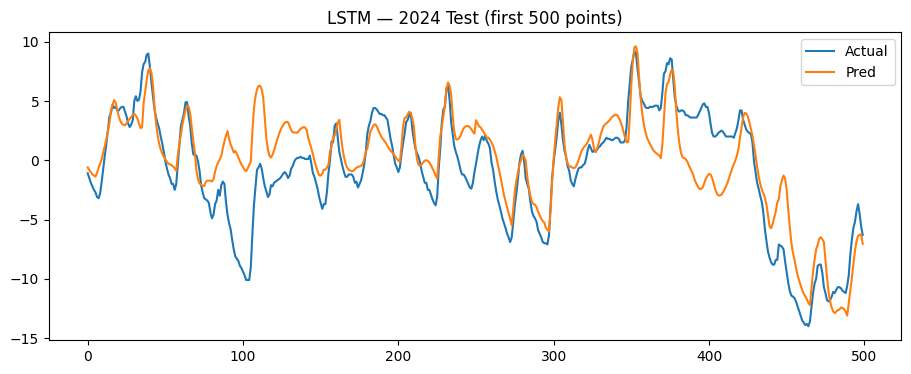

In [21]:
train_model(model, epochs=30, lr=1e-3, patience=6)

model.load_state_dict(torch.load("best.pt", map_location=DEVICE))
rmse_te, mae_te, y_true, y_pred = evaluate(model, test_loader)
print(f"[LSTM TEST24] RMSE={rmse_te:.3f} | MAE={mae_te:.3f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
N = min(500, len(y_true))
plt.plot(y_true[:N], label="Actual"); plt.plot(y_pred[:N], label="Pred")
plt.title("LSTM — 2024 Test (first 500 points)")
plt.legend(); plt.show()
